In [ ]:
# default_exp trajectory
# default_cls_lvl 3

# Trajectory Functions

> load and image and create a generator of a random walk trajectory ....

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
# export
import matplotlib.pyplot as plt
import cv2
import PIL
import numpy as np

In [ ]:
from nbdev.showdoc import *

## Basic functions

In [ ]:
# export
def show_img(im, figsize=None, ax=None, alpha=None):
    ' Show a numpy image '      
    if not ax: fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [ ]:
#export
def sliceImage(img, size, pos):
    "Take a small rectangular slice of a larger image `img`"
    
    sz0 = size[0] // 2
    sz1 = size[1] // 2

    pos[0] = min(pos[0], img.shape[0] - sz0)
    pos[0] = max(pos[0], 0 + sz0)
    pos[1] = min(pos[1], img.shape[1] - sz1)
    pos[1] = max(pos[1], 0 + sz1)

    b0 = pos[0] - sz0
    e0 = pos[0] + sz0
    b1 = pos[1] - sz1
    e1 = pos[1] + sz1

    # sl = img[b0:e0, b1:e1, :]
    sl = img[b0:e0, b1:e1]
    return sl, pos

the other args are the`size` and `pos`ition of the slice. If the position overlaps an edge the center is adjusted.
The slice anf actual position are returned, 

In [ ]:
#export
def rotate(image, angle, center=None, scale=1.0):
    "Rotate an image, about center and optionally scale"
    # grab the dimensions of the image
    (h, w) = image.shape[:2]

    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)

    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))

    # return the rotated image
    return rotated

In [ ]:
#export

def get_image_patch(img, pos, size=[400, 600], rot=0, scale=1.0):
    "get smaller image patch from `img` "
    exp_size = 200
    img0, cntr = sliceImage(img, [i+exp_size for i in size], pos[:2])
    rotated = rotate(img0, rot, scale=scale)
    img1, cntr0 = sliceImage(rotated, size, [(i+exp_size) // 2 for i in size])
    return img1, cntr

In [ ]:
#export

class Trajectory:
    "Creates a random walk trajectory of `length` steps based on the `img`"
    def __init__(self, img, length, xyscale=1, zscale=0.1, zcycles=3, acycles=3, deg=5, startpos=[1000,1000]):
        # global START_POS
        self.img = img
        self.startpos = startpos
        # START_POS = np.array(startpos)
        theta = 2 * np.pi * (np.random.rand(length) - 0.5) * 0.4
        theta = np.cumsum(theta, axis=0)
        z = np.sin(np.linspace(0, zcycles * 2 * np.pi, num=length)) * zscale + 1
        angles = (np.sin(np.linspace(0, acycles * 2 * np.pi, num=length)) * 0.5 + 0.5) * deg
        xy = np.column_stack((np.cos(theta), np.sin(theta)))
        xy[0,0], xy[0,1] = 0, 0  # start at zero
        xy = ((np.cumsum(xy, axis=0)) * xyscale)
        self.xyza = np.column_stack((xy, z, angles))
        self.i = 0
        self.length = length
               
    def __next__(self):
        if self.i < self.length:
            dy = int(self.xyza[self.i, 0] + self.startpos[0])
            dx = int(self.xyza[self.i, 1] + self.startpos[1])
            da = self.xyza[self.i, 3]
            self.i += 1
        else:
            raise StopIteration()
        
        cur_img, move_actual = get_image_patch(self.img, [dy, dx], rot=da)

        move_true = move_actual[0], move_actual[1], da

        return [cur_img, move_true]

        # return return_value
    def __iter__(self):
        return self
    

## Examples

### make a trajectory of 5 steps

In [ ]:
  
f = Trajectory(np.asarray(PIL.Image.open("Yosemite_NP_M.jpg")), 5)

for i in f:
    # print(next(f)[1]) 
    print(i[1]) 
    

(1000, 1000, 2.5)
(1000, 1000, 0.0)
(1001, 1000, 2.500000000000001)
(1002, 1000, 5.0)
(1003, 1000, 2.4999999999999982)


### make a trajectory of 50 steps and plot xy

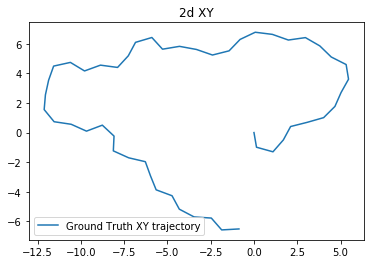

In [ ]:
f = Trajectory(np.asarray(PIL.Image.open("Yosemite_NP_M.jpg")), 50)
plt.plot(f.xyza[:,0], f.xyza[:,1])
plt.legend(['Ground Truth XY trajectory'])
plt.title('2d XY')
plt.show()

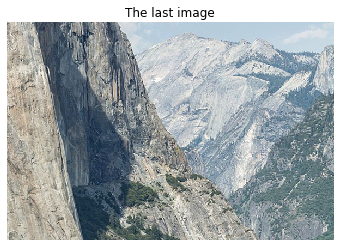

In [ ]:
# Show the last image
ax = show_img(i[0])
t = ax.set_title('The last image')


In [ ]:
#export
def mark_key_points(cur_img, key_pts):
    key_pts = np.int0(key_pts)
    img_marked = np.copy(cur_img)
    for i in key_pts:
        x, y = i.ravel()
        cv2.circle(img_marked, (x, y), 3, 255, -1)
    return img_marked

In [ ]:
def new_track_image_keypnts(img, trajectory, i):
    # global last_img
    cur_img, last_img, move_true = next_image(img, trajectory, i)

    move_calc, key_pts = track_features(cur_img, last_img)
    # last_img = np.copy(cur_img)

    img_marked = mark_key_points(cur_img, key_pts)

    return img_marked, move_true, move_calc, key_pts

In [ ]:
def track_features(img0, img1):
    img0_gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
    # Detect feature points in previous frame
    img0_pts = cv2.goodFeaturesToTrack(img0_gray,
                                       maxCorners=200,
                                       qualityLevel=0.2,
                                       minDistance=30,
                                       blockSize=5)

    # Convert to grayscale
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

    # Calculate optical flow (i.e. track feature points)
    img1_pts, status, err = cv2.calcOpticalFlowPyrLK(img0_gray, img1_gray, img0_pts, None)

    # Sanity check
    assert img0_pts.shape == img1_pts.shape

    # Filter only valid points
    idx = np.where(status == 1)[0]
    img0_pts = img0_pts[idx]
    img1_pts = img1_pts[idx]

    # Find transformation matrix
    (m, inliers) = cv2.estimateAffinePartial2D(img0_pts, img1_pts)  # will only work with OpenCV-3 or less

    # Extract translation
    dx = m[0, 2]
    dy = m[1, 2]

    # Extract rotation angle
    da = np.arctan2(m[1, 0], m[0, 0])
    # print("Tracked points : " + str(len(img0_pts)))

    return [dx, dy, da], img0_pts